# Coding Exercise: Implementing a Squeeze-and-Excitation (SE) Block Using Keras

In this exercise, you will learn to implement a Squeeze-and-Excitation (SE) block, a key component introduced in the SENet architecture. The SE block is designed to improve the representational power of a neural network by adaptively recalibrating channel-wise feature responses.

The Squeeze-and-Excitation (SE) block was introduced in the paper ["Squeeze-and-Excitation Networks"](https://arxiv.org/abs/1709.01507) by Jie Hu, Li Shen, and Gang Sun. The SE block adaptively recalibrates channel-wise feature responses by explicitly modeling interdependencies between channels. It consists of two main operations:

1. **Squeeze Step**: Apply global average pooling across the spatial dimensions of the feature maps.
2. **Excitation Step**: Pass the result through a small bottleneck (a Dense layer with reduced dimensionality) to capture channel-wise dependencies. Re-expand the squeezed features back to the original number of channels using another Dense layer with a sigmoid activation to generate scaling factors.

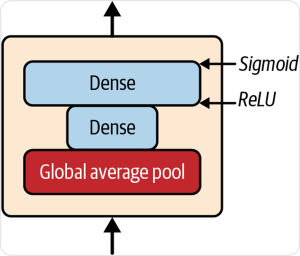

3. **Recalibrate Step**: Multiply the scaling factors with the original feature maps to recalibrate each channel.

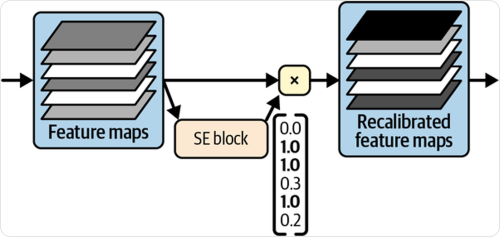

## Defining an SEBlock Layer

For this excercise your task is to complete the implementation of the SE block as a custom Keras layer. Steps:
1. Define the SE block as a subclass of `keras.layers.Layer`.
2. Implement the `__init__`, `build`, and `call` methods.
* `__init__`: Initialize the layer and set the reduction ratio.
* `build`: Define the weights or any operations that depend on the input shape.
* `call`: Implement the logic of the layer, which will apply the SE block operations (squeeze, excitation, and recalibration).
3. Integrate the custom SE block into a simple CNN model and test it.

You will need to use the following layers:
* [`GlobalAveragePooling2D`](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/): Global average pooling operation for 2D data.
* [`Dense`](https://keras.io/api/layers/core_layers/dense/): Just your regular densely-connected NN layer.
* [`Reshape`](https://keras.io/api/layers/reshaping_layers/reshape/): Layer that reshapes inputs into the given shape.
* [`Multiply`](https://keras.io/api/layers/merging_layers/multiply/):Performs elementwise multiplication. It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).

Refer to [Making new layers and models via subclassing
](https://keras.io/guides/making_new_layers_and_models_via_subclassing/) for a more in-depth discussion of custom Layer definition.

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

class SEBlock(layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        """
        Initializes the layer
        Args:
            reduction_ratio (int): Reduction ratio for the bottleneck in the excitation step.
        """
        super(SEBlock, self).__init__(**kwargs)  # Call to super __init__
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        """
        Create the learnable parameters and define any layer operations.
        Args:
            input_shape (tuple): The shape of the input tensor (batch_size, height, width, channels).
        """
        channels = input_shape[-1]
        
        self.global_avg_pool = layers.GlobalAveragePooling2D()

        self.dense1 = layers.Dense(channels // self.reduction_ratio, activation='relu')

        self.dense2 = layers.Dense(channels, activation='sigmoid')

        self.reshape = layers.Reshape((1, 1, channels))

        self.multiply = layers.Multiply()

        super(SEBlock, self).build(input_shape)

    def call(self, inputs):
        """
        Define the forward pass logic for the SE block.
        Args:
            inputs (tensor): Input tensor of shape (batch_size, height, width, channels).
        Returns:
            tensor: Output tensor after applying SE block (same shape as input).
        """
        squeeze = self.global_avg_pool(inputs)

        excitation = self.dense1(squeeze)
        excitation = self.dense2(excitation)

        excitation = self.reshape(excitation)

        output = self.multiply([inputs, excitation])

        return output

input_tensor = tf.keras.Input(shape=(32, 32, 64))  # Example input tensor
output_tensor = SEBlock()(input_tensor)  # Apply the SEBlock

model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_3 (SEBlock)            │ (None, 32, 32, 64)     │           580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 580 (2.27 KB)

 Trainable params: 580 (2.27 KB)

 Non-trainable params: 0 (0.00 B)

As a quick sanity check, let's test your `SEBlock` with a random tensor. Input and output shapes should be identical.

In [10]:
input_tensor = tf.random.normal([8, 32, 32, 64])

se_block = SEBlock()

output_tensor = se_block(input_tensor)

print(input_tensor.shape)
print(output_tensor.shape)

(8, 32, 32, 64)
(8, 32, 32, 64)


## Using the SEBlock Layer

Now that your `SEBlock` is ready, use it to build a simple CNN model for the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). We'll start by loading and preparing the data.

In [11]:
from keras.datasets import cifar10 #type: ignore
from keras.utils import to_categorical #type: ignore


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

CIFAR10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. You can visualize a sample of this images with the code below.

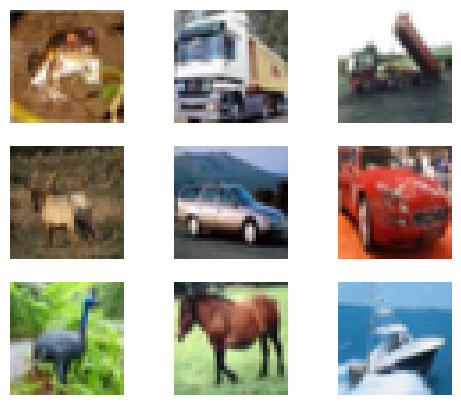

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
index = 0
for image in x_train[:9]:
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  #plt.title("Class: {}".format(class_names[label]))
  plt.axis("off")

plt.show()

It's time to build your model. The specific architecture is up to you, but make sure to employ the `SEBlock` and follow the design principles discussed in class (modularity, hierarchy, and reuse).

In [13]:
from keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense #type: ignore

def build_model_with_se(input_shape=(32, 32, 3), num_classes=10, se_ratio=16):
    inputs = layers.Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = SEBlock(reduction_ratio=se_ratio)(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, x)
    return model

model = build_model_with_se()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_5 (SEBlock)            │ (None, 8, 8, 64)       │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,286 (1.37 MB)

 Trainable params: 357,838 (1.37 MB)

 Non-trainable params: 448 (1.75 KB)

Complie and train your model.

In [14]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test), 
                    epochs=20, 
                    batch_size=64)

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.4523 - loss: 1.5697 - val_accuracy: 0.6380 - val_loss: 1.0402
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.6875 - loss: 0.8916 - val_accuracy: 0.6262 - val_loss: 1.1057
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.7391 - loss: 0.7428 - val_accuracy: 0.6699 - val_loss: 0.9695
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.7868 - loss: 0.6220 - val_accuracy: 0.7258 - val_loss: 0.8216
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.8068 - loss: 0.5554 - val_accuracy: 0.6694 - val_loss: 1.0317
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.8332 - loss: 0.4826 - val_accuracy: 0.7171 - val_loss: 0.8502
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.8562 - loss: 0.4165 - val_accuracy: 0.7620 - val_loss: 0.7163
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8748 - loss: 0.3658 - 

Plot training and validation accuracy and loss.

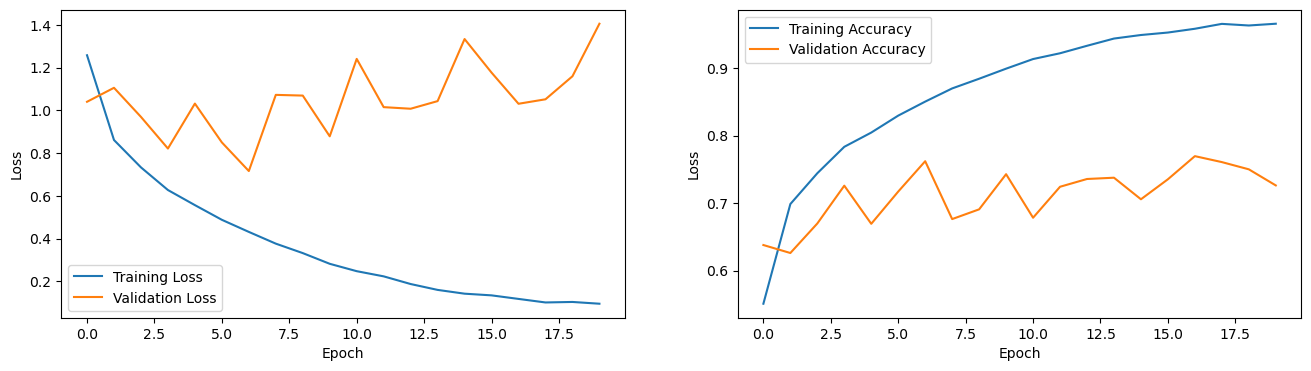

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Finally, evaluate with testing data (Note: model's test accuracy **won't** be factored into grade).

In [16]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")
model.save('ModelFinalCapas.keras')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7322 - loss: 1.3605
Test accuracy: 0.726
